# new version

In [7]:
import numpy as np

def detect_and_fix_rate_chunk(
    R,
    k=3.0,
    eps_sigma=1e-12,
    cancel_ratio=0.2,
    lag=1,
    fix_mode="both",   # "both"：修 spike+slip；"slip"：只修 slippage；"none"：不修

    # ===== 新增：幅度判据（amplitude gate）=====
    amp_ratio=None,    # 例如 2.0 表示突变幅度必须 > 2 * baseline
    amp_abs=None,      # 例如 2.0 表示突变幅度必须 > 2（按你的R单位）
    amp_q=75,          # baseline 用 |R| 的 q 分位（建议 75 或 80，避免 median=0）
    amp_apply="slip",  # "slip"：只对slippage加幅度判据；"both"：对spike+slip都加；"none"：不加
):
    """
    输入
    ----
    R : (T, Dc)  - 这里的 R 可以是 rate (ΔS/Δt) 或者你 dt=1 的 ΔS
    k : z-score 阈值（双侧）
    eps_sigma : sigma 太小则跳过该列检测，避免误爆
    cancel_ratio : spike 判别的“抵消程度”阈值，越小越严格（0.1~0.3 常用）
    lag : spike 回归的滞后（1 表示 t 和 t+1 互为正负；2 表示 t 和 t+2）
    fix_mode :
        - "both"  : 对所有候选异常点（spike + slippage）都插值修复（推荐）
        - "slip"  : 只对 slippage 插值修复（spike 不动）
        - "none"  : 不做修复，只输出 flag/统计

    输出
    ----
    R_corr      : (T, Dc) 修复后的 R
    slip_flag   : (T, Dc) int8, 只标 slippage，+1/-1/0
    spike_flag  : (T, Dc) int8, 只标 spike，  +1/-1/0

    n_slip_pos, n_slip_neg : (Dc,) 每列 slippage 正/负点数
    n_spike_pos,n_spike_neg: (Dc,) 每列 spike 正/负点数

    first_slip_pos, first_slip_neg : (Dc,) 第一次 slippage 正/负发生的 time_idx（无则 -1）
    first_spike_pos,first_spike_neg: (Dc,) 第一次 spike 正/负发生的 time_idx（无则 -1）
    """
    T, Dc = R.shape

    # # ---------- 1) 计算每列 z-score ----------
    mu = np.nanmean(R, axis=0)                    # (Dc,)
    sigma = np.nanstd(R, axis=0)                  # (Dc,)
    sigma = np.where(sigma < eps_sigma, np.nan, sigma)

    z = (R - mu[None, :]) / sigma[None, :]        # (T, Dc)

    # 候选异常点（双侧）
    cand = np.abs(z) > k                          # (T, Dc) bool

    # 方向（仅在 cand 位置才有意义）
    flag_all = (z > k).astype(np.int8) - (z < -k).astype(np.int8)   # +1/-1/0
    mask_z = cand & (flag_all != 0)




    # ---------- 1) robust center/scale：median + MAD ----------
    # med = np.nanmedian(R, axis=0)  # (Dc,)
    # mad = np.nanmedian(np.abs(R - med[None, :]), axis=0)  # (Dc,)

    # # 将 MAD 换算成“robust sigma”（正态假设下等价于 std）
    # sigma = 1.4826 * mad

    # # sigma 太小则跳过该列检测（避免误爆/除零）
    # sigma = np.where(sigma < eps_sigma, np.nan, sigma)

    # # robust z-score
    # z = (R - med[None, :]) / sigma[None, :]  # (T, Dc)

    # # 候选异常点（双侧）
    # cand = np.abs(z) > k
    # flag_all = (z > k).astype(np.int8) - (z < -k).astype(np.int8)   # +1/-1/0
    # mask_z = cand & (flag_all != 0)



    # ---------- 1.5) 新增：幅度判据（amplitude gate） ----------
    # baseline：每列 |R| 的 amp_q 分位（75%/80%一般比median更稳）
    if (amp_ratio is None) and (amp_abs is None):
        amp_mask = np.ones_like(mask_z, dtype=bool)  # 不加幅度筛选
    else:
        absR = np.abs(R)
        baseline = np.nanpercentile(absR, amp_q, axis=0)  # (Dc,)
        # 防止 baseline=0 导致阈值=0（可按需要加一个很小的floor）
        baseline = np.where(baseline <= 0, np.nan, baseline)

        thr = np.zeros((Dc,), dtype=np.float32)
        if amp_abs is not None:
            thr = np.maximum(thr, float(amp_abs))
        if amp_ratio is not None:
            thr = np.maximum(thr, float(amp_ratio) * baseline)

        # amp_ok：|R| >= thr
        amp_ok = absR >= thr[None, :]
        # baseline=nan 的列，不做幅度筛选（也可以改成全部False，看你想更严格还是更宽松）
        amp_ok = np.where(np.isnan(thr[None, :]), True, amp_ok)

        amp_mask = amp_ok

    # 根据 amp_apply 决定 amplitude gate 作用范围
    if amp_apply == "none":
        mask = mask_z
    elif amp_apply == "both":
        mask = mask_z & amp_mask
    elif amp_apply == "slip":
        mask = mask_z  # spike识别仍用mask_z；slippage时再加幅度
    else:
        raise ValueError("amp_apply must be 'slip', 'both', or 'none'")


    # ---------- 2) spike 识别：相邻（或隔lag）异号 + 抵消 ----------
    # 这里用 mask_z 做 spike 识别更稳（不然你只对slip加幅度时也能识别spike）
    spike_mask = np.zeros_like(mask_z, dtype=bool)

    if lag == 1:
        a = mask_z[:-1, :]
        b = mask_z[1:, :]
        opposite = (flag_all[:-1, :] == -flag_all[1:, :])
        # 近似抵消：|R[t] + R[t+1]| 足够小
        cancel = np.abs(R[:-1, :] + R[1:, :]) <= cancel_ratio * np.maximum(np.abs(R[:-1, :]), np.abs(R[1:, :]))
        pair = a & b & opposite & cancel
        spike_mask[:-1, :] |= pair
        spike_mask[1:,  :] |= pair

    elif lag == 2:
        a = mask_z[:-2, :]
        b = mask_z[2:, :]
        opposite = (flag_all[:-2, :] == -flag_all[2:, :])
        cancel = np.abs(R[:-2, :] + R[2:, :]) <= cancel_ratio * np.maximum(np.abs(R[:-2, :]), np.abs(R[2:, :]))
        pair = a & b & opposite & cancel
        spike_mask[:-2, :] |= pair
        spike_mask[2:,  :] |= pair
    else:
        raise ValueError("lag 目前只支持 1 或 2")


    # ---------- 3) slippage = 异常候选 - spike，并可加幅度判据 ----------
    slip_mask = mask_z & (~spike_mask)

    # 如果 amp_apply="slip"，就在这里对 slippage 加幅度门槛
    if amp_apply == "slip":
        slip_mask = slip_mask & amp_mask
        # spike 是否也要加幅度？如果你希望 spike 也更少，把 amp_apply 改成 "both"

    # 如果 amp_apply="both"，mask 已经加过幅度，slip/spike也应一致收缩
    if amp_apply == "both":
        spike_mask = spike_mask & amp_mask
        slip_mask  = slip_mask  & amp_mask

    spike_flag = (flag_all * spike_mask.astype(np.int8)).astype(np.int8)
    slip_flag  = (flag_all * slip_mask.astype(np.int8)).astype(np.int8)


    # ---------- 4) 决定修复哪些点 ----------
    if fix_mode == "both":
        fix_mask = (spike_mask | slip_mask)
    elif fix_mode == "slip":
        fix_mask = slip_mask
    elif fix_mode == "none":
        fix_mask = np.zeros_like(mask_z, dtype=bool)
    else:
        raise ValueError("fix_mode must be 'both', 'slip', or 'none'")

    # ---------- 5) 插值修复（逻辑基本沿用你原来的） ----------
    R_corr = R.copy()

    # 修复“孤立异常点”（前后都正常）
    mask_prev = np.vstack([np.zeros((1, Dc), dtype=bool), fix_mask[:-1]])
    mask_next = np.vstack([fix_mask[1:], np.zeros((1, Dc), dtype=bool)])
    isolated = fix_mask & (~mask_prev) & (~mask_next)
    isolated[0, :] = False
    isolated[-1, :] = False

    prev = np.roll(R_corr, 1, axis=0); prev[0, :] = np.nan
    nxt  = np.roll(R_corr, -1, axis=0); nxt[-1, :] = np.nan
    avg = 0.5 * (prev + nxt)
    R_corr[isolated] = avg[isolated]

    # 连续异常段：按列线性插值
    remain = fix_mask & (~isolated)
    cols_need = np.where(remain.any(axis=0))[0]
    t = np.arange(T)

    for j in cols_need:
        bad = remain[:, j]
        good = (~bad) & (~np.isnan(R_corr[:, j]))
        if good.sum() < 2:
            continue
        R_corr[bad, j] = np.interp(t[bad], t[good], R_corr[good, j])


    # ---------- 6) 统计与首次发生时间 ----------
    def first_index_of_true(mat_bool):
        """mat_bool: (T, Dc) -> first true index per col, else -1"""
        first = np.full((Dc,), -1, dtype=np.int32)
        any_ = mat_bool.any(axis=0)
        if any_.any():
            first[any_] = np.argmax(mat_bool[:, any_], axis=0).astype(np.int32)
        return first

    n_slip_pos = (slip_flag ==  1).sum(axis=0).astype(np.int32)
    n_slip_neg = (slip_flag == -1).sum(axis=0).astype(np.int32)
    n_spike_pos= (spike_flag == 1).sum(axis=0).astype(np.int32)
    n_spike_neg= (spike_flag ==-1).sum(axis=0).astype(np.int32)

    first_slip_pos  = first_index_of_true(slip_flag == 1)
    first_slip_neg  = first_index_of_true(slip_flag ==-1)
    first_spike_pos = first_index_of_true(spike_flag == 1)
    first_spike_neg = first_index_of_true(spike_flag ==-1)

    return (R_corr,
            slip_flag, spike_flag,
            n_slip_pos, n_slip_neg, n_spike_pos, n_spike_neg,
            first_slip_pos, first_slip_neg, first_spike_pos, first_spike_neg)

def rebuild_strain_from_rate(R_corr, S0, dt=1.0):
    """锚定第一行 S0，用修复后的 rate 重建 strain change。"""
    T, Dc = R_corr.shape
    S_corr = np.empty((T, Dc), dtype=np.float32)
    S_corr[0, :] = S0
    S_corr[1:, :] = S0 + np.cumsum(R_corr[1:, :] * dt, axis=0)
    return S_corr

In [ ]:

import h5py
import numpy as np

in_strain_path = r"C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/Evo_5_6_7_Sep_2025/Evo 7 (flowback)/Zgabay A14H - flowback - strain change.h5"
in_rate_path   = r"C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/Evo_5_6_7_Sep_2025/Evo 7 (flowback)/Zgabay A14H - flowback - strain change rate.h5"
out_path       = r"C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/Evo_5_6_7_Sep_2025/Evo 7 (flowback)/corrected_3sigma_both_sides.h5"


# 你已有的参数
DEPTH_CHUNK = 1024
K = 8
dt = 1.0

# spike 判别参数
CANCEL_RATIO = 0.2
LAG = 1

# 修复策略： "both" 或 "slip"
FIX_MODE = "slip"

with h5py.File(in_strain_path, "r") as fS, h5py.File(in_rate_path, "r") as fR, h5py.File(out_path, "w") as fout:
    S_ds = fS["data"]        # (T, D)
    R_ds = fR["data"]        # (T, D)
    depth  = fR["depth"][:]  # (D,)
    stamps = fR["stamps"][:] # (T,)

    T, D = R_ds.shape

    fout.create_dataset("depth", data=depth)
    fout.create_dataset("stamps", data=stamps)

    d_rate = fout.create_dataset(
        "rate_corrected", shape=(T, D), dtype="float32",
        chunks=(min(T, 512), min(D, DEPTH_CHUNK)),
        compression="gzip", compression_opts=4
    )
    d_strain = fout.create_dataset(
        "strain_corrected", shape=(T, D), dtype="float32",
        chunks=(min(T, 512), min(D, DEPTH_CHUNK)),
        compression="gzip", compression_opts=4
    )

    # 两类 flag：slippage vs spike
    d_slip_flag = fout.create_dataset(
        "slippage_flag", shape=(T, D), dtype="int8",   # -1/0/+1
        chunks=(min(T, 512), min(D, DEPTH_CHUNK)),
        compression="gzip", compression_opts=4
    )
    d_spike_flag = fout.create_dataset(
        "spike_flag", shape=(T, D), dtype="int8",      # -1/0/+1
        chunks=(min(T, 512), min(D, DEPTH_CHUNK)),
        compression="gzip", compression_opts=4
    )

    # 每个深度通道的统计：slippage
    d_slip_npos = fout.create_dataset("n_slip_pos", shape=(D,), dtype="int32")
    d_slip_nneg = fout.create_dataset("n_slip_neg", shape=(D,), dtype="int32")
    d_slip_fpos = fout.create_dataset("first_slip_pos_t", shape=(D,), dtype="int32")
    d_slip_fneg = fout.create_dataset("first_slip_neg_t", shape=(D,), dtype="int32")

    # 每个深度通道的统计：spike
    d_spike_npos = fout.create_dataset("n_spike_pos", shape=(D,), dtype="int32")
    d_spike_nneg = fout.create_dataset("n_spike_neg", shape=(D,), dtype="int32")
    d_spike_fpos = fout.create_dataset("first_spike_pos_t", shape=(D,), dtype="int32")
    d_spike_fneg = fout.create_dataset("first_spike_neg_t", shape=(D,), dtype="int32")

    for j0 in range(0, D, DEPTH_CHUNK):
        j1 = min(D, j0 + DEPTH_CHUNK)

        R = R_ds[:, j0:j1].astype(np.float32)
        S0 = S_ds[0, j0:j1].astype(np.float32)

        (R_corr,
         slip_flag, spike_flag,
         n_slip_pos, n_slip_neg, n_spike_pos, n_spike_neg,
         first_slip_pos, first_slip_neg, first_spike_pos, first_spike_neg) = detect_and_fix_rate_chunk(
            R,
            k=K,
            cancel_ratio=CANCEL_RATIO,
            lag=LAG,
            fix_mode=FIX_MODE,
            amp_ratio=2.0,   # 两倍
            amp_q=75,        # baseline用75分位
            amp_apply="slip", # 只对slippage加幅度判据,如果你发现 spike 也还是特别多、想同时减少 spike，就把： amp_apply 改成 "both"
            #amp_abs=2.0     # 如果你想加一个“绝对幅度阈值”（比如单位上你觉得 ΔS 超过 2 才算大）,这样阈值是 max(2.0, 2.0*baseline)
                                #只有当你对 R 的物理单位有把握时再用；否则先用 ratio + 分位 baseline。
        )

        # 你原来的重建函数
        S_corr = rebuild_strain_from_rate(R_corr, S0, dt=dt)

        d_rate[:, j0:j1] = R_corr
        d_strain[:, j0:j1] = S_corr

        d_slip_flag[:, j0:j1] = slip_flag
        d_spike_flag[:, j0:j1] = spike_flag

        d_slip_npos[j0:j1] = n_slip_pos
        d_slip_nneg[j0:j1] = n_slip_neg
        d_slip_fpos[j0:j1] = first_slip_pos
        d_slip_fneg[j0:j1] = first_slip_neg

        d_spike_npos[j0:j1] = n_spike_pos
        d_spike_nneg[j0:j1] = n_spike_neg
        d_spike_fpos[j0:j1] = first_spike_pos
        d_spike_fneg[j0:j1] = first_spike_neg

print("Done:", out_path)


Done: C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/Evo_5_6_7_Sep_2025/Evo 7 (flowback)/corrected_3sigma_both_sides.h5


# results

In [10]:
import h5py
import numpy as np
import pandas as pd

# =========================
# 配置
# =========================
out_path = r"C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/Evo_5_6_7_Sep_2025/Evo 7 (flowback)/corrected_3sigma_both_sides.h5"
z0, z1 = 36274, 49848   # 通道区间 [z0, z1)
TOP_N = 15              # 打印事件最多的通道数
MAX_EVENTS_DF = 500000  # 生成事件表时防爆上限（太大就截断）


def _decode_stamp(x):
    return x.decode() if isinstance(x, (bytes, np.bytes_)) else str(x)


def summarize_interval(out_path, z0, z1, top_n=15):
    """快速汇总区间内 slippage/spike 情况，不读全矩阵。"""
    with h5py.File(out_path, "r") as f:
        depth  = f["depth"][z0:z1]
        stamps = f["stamps"][:]

        n_slip_pos = f["n_slip_pos"][z0:z1]
        n_slip_neg = f["n_slip_neg"][z0:z1]
        n_spike_pos = f["n_spike_pos"][z0:z1]
        n_spike_neg = f["n_spike_neg"][z0:z1]

        f_slip_pos = f["first_slip_pos_t"][z0:z1]
        f_slip_neg = f["first_slip_neg_t"][z0:z1]
        f_spike_pos = f["first_spike_pos_t"][z0:z1]
        f_spike_neg = f["first_spike_neg_t"][z0:z1]

    slip_total = n_slip_pos + n_slip_neg
    spike_total = n_spike_pos + n_spike_neg

    slip_cols_local = np.where(slip_total > 0)[0]
    spike_cols_local = np.where(spike_total > 0)[0]

    print("========== 区间汇总 ==========")
    print(f"通道区间: [{z0}, {z1-1}]  (共 {z1-z0} 条)")
    print(f"发生过 slippage 的通道数: {slip_cols_local.size}  ({100*slip_cols_local.size/(z1-z0):.2f}%)")
    print(f"发生过 spike 的通道数   : {spike_cols_local.size} ({100*spike_cols_local.size/(z1-z0):.2f}%)")
    print(f"区间内 slippage 总事件点数: {int(slip_total.sum())}   (+{int(n_slip_pos.sum())}/-{int(n_slip_neg.sum())})")
    print(f"区间内 spike 总事件点数   : {int(spike_total.sum())}  (+{int(n_spike_pos.sum())}/-{int(n_spike_neg.sum())})")

    # 打印 slippage 最多的通道 Top-N
    print("\n---- Slippage Top channels ----")
    if slip_cols_local.size == 0:
        print("（无 slippage 通道）")
    else:
        top_local = slip_cols_local[np.argsort(slip_total[slip_cols_local])[::-1]][:top_n]
        for iloc in top_local:
            iglob = iloc + z0
            # 找第一次发生时间（取正负里更早的那个）
            tcands = [t for t in [f_slip_pos[iloc], f_slip_neg[iloc]] if t >= 0]
            t0 = min(tcands) if tcands else -1
            ts = _decode_stamp(stamps[t0]) if t0 >= 0 else "NA"
            print(f"depth_idx={iglob:6d}, depth={depth[iloc]:.2f}, total={slip_total[iloc]}, +={n_slip_pos[iloc]}, -={n_slip_neg[iloc]}, first={t0} ({ts})")

    # 打印 spike 最多的通道 Top-N
    print("\n---- Spike Top channels ----")
    if spike_cols_local.size == 0:
        print("（无 spike 通道）")
    else:
        top_local = spike_cols_local[np.argsort(spike_total[spike_cols_local])[::-1]][:top_n]
        for iloc in top_local:
            iglob = iloc + z0
            tcands = [t for t in [f_spike_pos[iloc], f_spike_neg[iloc]] if t >= 0]
            t0 = min(tcands) if tcands else -1
            ts = _decode_stamp(stamps[t0]) if t0 >= 0 else "NA"
            print(f"depth_idx={iglob:6d}, depth={depth[iloc]:.2f}, total={spike_total[iloc]}, +={n_spike_pos[iloc]}, -={n_spike_neg[iloc]}, first={t0} ({ts})")

    return {
        "slip_cols_global": slip_cols_local + z0,
        "spike_cols_global": spike_cols_local + z0
    }


def show_channel_events(out_path, depth_idx, kind="slip", max_show=80):
    """
    打印某个通道的事件时间点与方向：
      kind="slip" 看 slippage_flag
      kind="spike" 看 spike_flag
    """
    flag_name = "slippage_flag" if kind == "slip" else "spike_flag"

    with h5py.File(out_path, "r") as f:
        depth_val = float(f["depth"][depth_idx])
        stamps = f["stamps"][:]
        flag = f[flag_name][:, depth_idx].astype(np.int8)

    t_idx = np.where(flag != 0)[0]
    sign = flag[t_idx]

    print(f"\n========== {kind.upper()} events for depth_idx={depth_idx}, depth={depth_val:.2f} ==========")
    print("events =", len(t_idx))
    for t, s in zip(t_idx[:max_show], sign[:max_show]):
        ts = _decode_stamp(stamps[t])
        direction = "UP (+1)" if s == 1 else "DOWN (-1)"
        print(f"  t={t:4d}, stamp={ts}, sign={int(s)} {direction}")


def build_events_df_interval(out_path, z0, z1, kind="slip", max_events=500000):
    """
    生成区间内事件表 DataFrame：
      kind="slip" / "spike"
    """
    flag_name = "slippage_flag" if kind == "slip" else "spike_flag"

    with h5py.File(out_path, "r") as f:
        depth = f["depth"][z0:z1]
        stamps = f["stamps"][:]
        blk = f[flag_name][:, z0:z1]  # (T, Dc)

    t_rel, z_rel = np.nonzero(blk)
    if t_rel.size == 0:
        return pd.DataFrame(columns=["time_idx", "stamp", "depth_idx", "depth", "sign", "direction"])

    # 防爆截断
    if t_rel.size > max_events:
        idx = np.random.RandomState(0).choice(t_rel.size, size=max_events, replace=False)
        t_rel = t_rel[idx]
        z_rel = z_rel[idx]

    sign = blk[t_rel, z_rel].astype(np.int8)

    depth_idx = z_rel + z0
    depth_val = depth[z_rel].astype(np.float32)
    stamp_sel = np.array([_decode_stamp(stamps[t]) for t in t_rel], dtype=object)

    df = pd.DataFrame({
        "time_idx": t_rel.astype(np.int32),
        "stamp": stamp_sel,
        "depth_idx": depth_idx.astype(np.int32),
        "depth": depth_val,
        "sign": sign
    })
    df["direction"] = np.where(df["sign"] == 1, "UP", "DOWN")
    df = df.sort_values(["depth_idx", "time_idx"]).reset_index(drop=True)
    return df


# =========================
# 运行示例
# =========================

# 1) 区间汇总 + top 通道
res = summarize_interval(out_path, z0, z1, top_n=TOP_N)

# 2) 看某一条通道（你可以从 res['slip_cols_global'] 里挑一个）
if res["slip_cols_global"].size > 0:
    example_idx = int(res["slip_cols_global"][0])
    show_channel_events(out_path, example_idx, kind="slip", max_show=60)

if res["spike_cols_global"].size > 0:
    example_idx2 = int(res["spike_cols_global"][0])
    show_channel_events(out_path, example_idx2, kind="spike", max_show=60)

# # 3) 生成区间内 slippage 事件表，并导出 CSV
# df_slip = build_events_df_interval(out_path, z0, z1, kind="slip", max_events=MAX_EVENTS_DF)
# print("\nslippage df head:\n", df_slip.head())
# print("slippage events in interval:", len(df_slip))
# df_slip.to_csv(out_path.replace(".h5", f"_slippage_events_{z0}_{z1-1}.csv"), index=False)

# # 4) 生成区间内 spike 事件表，并导出 CSV
# df_spike = build_events_df_interval(out_path, z0, z1, kind="spike", max_events=MAX_EVENTS_DF)
# print("\nspike df head:\n", df_spike.head())
# print("spike events in interval:", len(df_spike))
# df_spike.to_csv(out_path.replace(".h5", f"_spike_events_{z0}_{z1-1}.csv"), index=False)


========== 区间汇总 ==========
通道区间: [36274, 49847]  (共 13574 条)
发生过 slippage 的通道数: 2775  (20.44%)
发生过 spike 的通道数   : 86 (0.63%)
区间内 slippage 总事件点数: 3111   (+1262/-1849)
区间内 spike 总事件点数   : 430  (+215/-215)

---- Slippage Top channels ----
depth_idx= 48535, depth=16056.21, total=15, +=9, -=6, first=3252 (06/07/2022 03:17:28.425011)
depth_idx= 46707, depth=15451.48, total=14, +=8, -=6, first=2190 (06/05/2022 05:43:26.383745)
depth_idx= 45869, depth=15174.26, total=10, +=6, -=4, first=689 (06/02/2022 13:16:59.558281)
depth_idx= 49736, depth=16453.53, total=10, +=5, -=5, first=653 (06/02/2022 11:44:14.179914)
depth_idx= 46760, depth=15469.01, total=8, +=4, -=4, first=1981 (06/04/2022 20:45:01.875839)
depth_idx= 47472, depth=15704.56, total=8, +=5, -=3, first=1566 (06/04/2022 02:56:57.759380)
depth_idx= 47460, depth=15700.59, total=7, +=5, -=2, first=1640 (06/04/2022 06:07:52.916642)
depth_idx= 45795, depth=15149.78, total=7, +=3, -=4, first=3367 (06/07/2022 08:13:18.709638)
depth_idx= 47607, 

# Waterfall plot

In [1]:
# import packages
import h5py # read h5

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import MultipleLocator, FuncFormatter, MaxNLocator, ScalarFormatter, FixedLocator, LogFormatter

import datetime
from matplotlib import rc
from cycler import cycler

import numpy as np
import pandas as pd


# download and install Dr. Jin's python package, click the url below for more details
# !git clone https://github.com/jinwar/jin_pylib

from jin_pylib import gjsignal
from jin_pylib import Data2D_XT


In [2]:
# Read h5 files
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/Evo 3 (refrac)/Neubrex_DSS_strain/Zgabay A14H - refrac - strain change.h5','r')
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/Evo 5 (POP)/Zgabay A14H - pop - strain change.h5','r')
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/Evo_5_6_7_Sep_2025/Evo 6 (choke)/Zgabay A14H - choke - strain change rate.h5','r')
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/Evo_5_6_7_Sep_2025/Evo 7 (flowback)/Zgabay A14H - flowback - strain change.h5','r')
f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/Evo_5_6_7_Sep_2025/Evo 7 (flowback)/corrected_Evo7.h5','r')




print(list(f1.keys()))

['depth', 'first_slip_neg_t', 'first_slip_pos_t', 'first_spike_neg_t', 'first_spike_pos_t', 'n_slip_neg', 'n_slip_pos', 'n_spike_neg', 'n_spike_pos', 'rate_corrected', 'slippage_flag', 'spike_flag', 'stamps', 'strain_corrected']


In [3]:
from matplotlib import rc
from cycler import cycler

# Figure format
rc = {'axes.facecolor':'white',
      'figure.figsize': (12, 6),
      'savefig.dpi': 600,
#       'axes.grid' : False,
      'axes.edgecolor' : '0.15',
      
      'font.family':'Times New Roman',
      'font.serif': ['Times New Roman', 'Times', 'STIXGeneral'],  # 备选
      # —— 数学字体（$...$ 内）——
      'mathtext.fontset': 'stix',     # 关键：让 μ、ε 等用 STIX（Times 风格）
      'axes.unicode_minus': False,    # 让负号显示为正常的连字符


      'axes.labelsize': 20,         # X、Y 轴标题字体
      'axes.labelweight': 'bold',   # X、Y 轴标题加粗
      'xtick.labelsize': 20,        # X轴刻度文字
      'ytick.labelsize': 20,        # Y轴刻度文字
      'legend.fontsize': 20,       # 图例字体

      # 线宽与颜色顺序
      'lines.linewidth': 2.25,      # 所有线条默认 2.25 pt
      'axes.prop_cycle': cycler('color', list(('k', 'r', 'b', 'g', 'm', 'c', 'y'))),

      # 刻度朝外 & 粗细
      'xtick.direction': 'out',
      'ytick.direction': 'out',
      'xtick.major.size': 6,
      'ytick.major.size': 6,
      'xtick.major.width': 2.0,
      'ytick.major.width': 2.0,

      # 坐标轴（内框）线宽
      'axes.linewidth': 2.0,
      } 
# lack of font size
plt.rcParams.update(rc)

In [11]:
# Assign variables
dstrain = (f1['rate_corrected'])  #（time, depth）
depth = (f1['depth'])
date_plot = (f1['stamps'])

# use panda package
# print(pd.DataFrame(dstrain))
print(pd.DataFrame(depth))
# print(pd.DataFrame(date_plot))

                  0
0          0.039095
1          0.372001
2          0.701719
3          1.031387
4          1.364292
...             ...
57199  18922.408203
57200  18922.738281
57201  18923.070312
57202  18923.398438
57203  18923.728516

[57204 rows x 1 columns]


In [12]:
# convert the strain data to numpy array
dstrain = np.array(dstrain)
print(dstrain.shape)

# date_plot = np.array(date_plot)

(3415, 57204)


In [13]:
#depth 和相邻depth的差值
print(np.diff(depth))
average_diff = np.mean(np.diff(depth))
print(average_diff)


[0.3329055  0.32971793 0.32966805 ... 0.33203125 0.328125   0.33007812]
0.3308164


In [14]:
# deal with time array
# print(type(date_plot))  # h5py._hl.dataset.Dataset
# 1) encoding 
arr_bytes = date_plot[...]                      # numpy.ndarray
# print(type(arr_bytes),"arr_bytes")              # numpy.ndarray
arr_str   = np.char.decode(arr_bytes, 'utf-8')  # 向量化解码为 ndarray[str]
# print(type(arr_str),"arr_str")                      # ndarray[str]
datetime_index = pd.to_datetime(arr_str, format="%m/%d/%Y %H:%M:%S.%f")
# print(type(datetime_index))                           # pandas.core.indexes.datetimes.DatetimeIndex
# print("datetime_index\n",datetime_index)

# 2) calculate the start time
dtimes = datetime_index.to_pydatetime()  # type = numpy.ndarray, element type = datetime.datetime
startdate = dtimes[0]
print("startdate-->",startdate)  # 2022-03-14 20:56:49.350706

# 3) calculate average time interval in seconds
deltas = datetime_index.to_series().diff().dropna()   # dropna() 去掉第一个 NaT
print("deltas-->",type(deltas),"\nelement inside-->",type(deltas.iloc[0]))  # pandas.core.series.Series，元素类型为 Timedelta
mean_seconds = deltas.dt.total_seconds().mean()
print("mean_seconds",type(mean_seconds))  # float
print("平均间隔 (秒):", mean_seconds)


# 4) set the time axis for DASdata
t_intrvl = np.round(mean_seconds) # time interval in seconds 
t_axis = 1 + t_intrvl * np.arange(len(date_plot))        # array([1, 146, 291, ...])
t_axis = t_axis.tolist() 


# ts_np = np.array(ts)   # 如果 ts 是 DatetimeIndex，这会生成 datetime64[ns] 数组

# # 1) 计算相邻差（结果是 timedelta64[ns]）
# diffs = np.diff(ts_np)

# # 2) 把 timedelta64[ns] 转换为秒（浮点）
# # 方法：astype('timedelta64[ns]') -> 将其转换为数值（以 ns 为单位），然后除以 1e9
# diffs_ns = diffs.astype('timedelta64[ns]').astype(np.int64)   # ns 为单位的整数
# diffs_seconds = diffs_ns / 1e9

# # 3) 平均秒数
# mean_seconds = np.mean(diffs_seconds)

# print("前 5 个相邻差值（秒）:", diffs_seconds[:5])
# print("平均间隔 (秒):", mean_seconds)


startdate--> 2022-06-01 07:46:11.600838
deltas--> <class 'pandas.core.series.Series'> 
element inside--> <class 'pandas._libs.tslibs.timedeltas.Timedelta'>
mean_seconds <class 'numpy.float64'>
平均间隔 (秒): 154.44229406121852


In [15]:
data = dstrain #(time, depth）

# creating a Data2D class instance

DASdata = Data2D_XT.Data2D() # initiate instance
DASdata.data = data.T   # DAS data in 2D array, the first axis is distance and second axis is time

# DASdata.taxis = pd.date_range(start = date_plot[0],end = date_plot[-1],periods = len(date_plot))
DASdata.taxis = t_axis

DASdata.daxis = np.arange(data.shape[1])*average_diff  # 1D array for distance grid, unit in ft
DASdata.start_time = startdate

DASdata.daxis[-1]
print(DASdata.data.shape)

(57204, 3415)


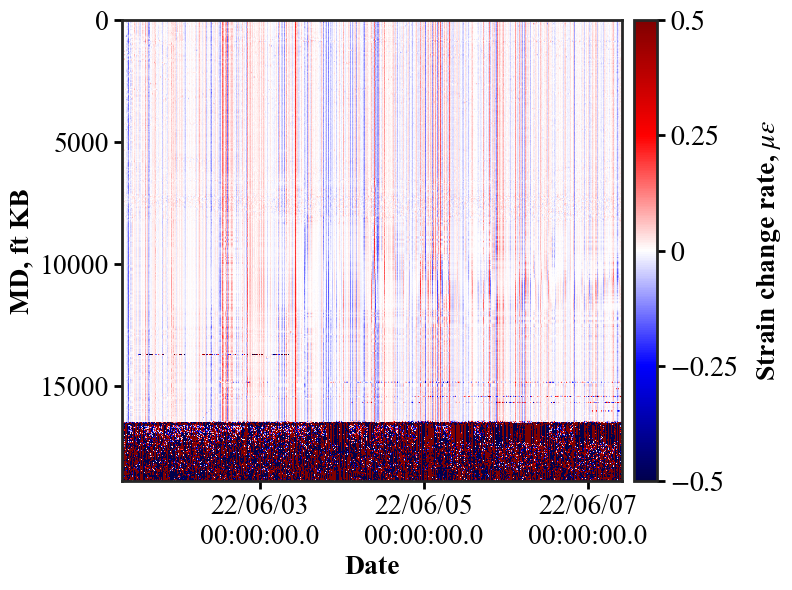

In [18]:
# cx = np.array([-1,1])
# DASdata.plot_waterfall(timescale='second',use_timestamp=True,timefmt = '%m/%d\n%H:%M:%S.{ms}')
fig, ax = plt.subplots(figsize = (8,6))
DASdata.plot_waterfall(timescale='second',use_timestamp=True,cmap=plt.get_cmap('seismic'),xtickN=4)
ax = plt.gca()
im = ax.images[-1]
im.set_norm(TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5))  # 以 0 为中心
# 或者：im.set_clim(-10, 10)

cbar = fig.colorbar(im, ax=ax, pad=0.02) # pad 调整颜色条与图的距离pad 数值越大越远（相对于轴宽度的比例）


ax.set_ylabel("MD, ft KB", fontweight='bold')
ax.set_xlabel("Date",     fontweight='bold')

# -----------------set custom ticks--------------

# # X 轴
# ax.set_xticks([t0, t1, t2])                     # 位置（数据坐标）
# ax.set_xticklabels(['Start', 'Mid', 'End'])     # 文本（与上面位置一一对应）

# # Y 轴
# ax.set_yticks([0, 5000, 10000])
# ax.set_yticklabels(['0', '5k', '10k'])

# 均匀间隔
# ax.xaxis.set_major_locator(MultipleLocator(3600))     # 每 3600 秒一个大刻度
ax.yaxis.set_major_locator(MultipleLocator(5000))     # 每 2000 ft 一个大刻度

# # 控制刻度文本格式（自定义函数）
# ax.xaxis.set_major_formatter(FuncFormatter(lambda v, pos: f'{v/3600:.1f} h'))
# ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f'{v:.0f}'))

# # 或者仅控制“最多几个刻度”
# ax.xaxis.set_major_locator(MaxNLocator(nbins=5))

# # cbar
# 位置：固定到想要的几档
cbar.set_ticks([-0.5, -0.25, 0, 0.25, 0.5])                 # 或 cbar.ax.yaxis.set_major_locator(FixedLocator([...]))
# 文本：逐个指定（可含数学字体）
cbar.set_ticklabels([r'$-0.5$', r'$-0.25$', r'$0$', r'$0.25$', r'$0.5$'])

# # 或者用 Formatter 自动生成文本
# cbar.formatter = FuncFormatter(lambda v, pos: f'{v:.1f}')
# cbar.update_normal(im)   # 某些版本需要刷新一下

# 标签（单位）
cbar.set_label(r'Strain change rate, $\mu\varepsilon$', rotation=90, labelpad=12)


plt.tight_layout()
plt.savefig('waterfall_ori.png',dpi=1200)


# plot strain v.s. time in some certain depth

(3415, 57204)


Text(0, 0.5, 'Strain change rate, $\\mu\\varepsilon$')

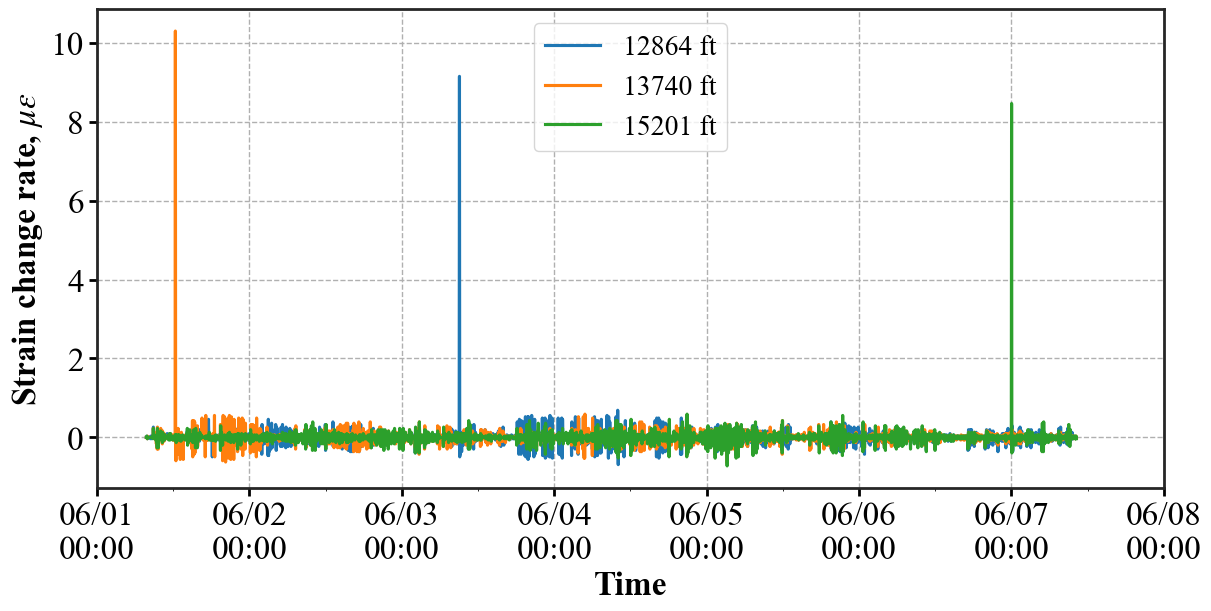

In [21]:
%reload_ext autoreload
%autoreload 2

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib.ticker import MultipleLocator, FuncFormatter, MaxNLocator, ScalarFormatter, FixedLocator, LogFormatter
from dateutil.rrule import rrule, HOURLY, DAILY

import sys
from pathlib import Path
# 把 project/ 加到模块搜索路径
sys.path.insert(0, str(Path().resolve().parent))
from plot_style import plot_strain_vs_time_at_depths, decode_stamps_to_datetimeindex, save_figure


# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/Evo 3 (refrac)/Neubrex_DSS_strain/Zgabay A14H - refrac - strain change.h5','r')
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/Evo 5 (POP)/Zgabay A14H - pop - strain change.h5','r')
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/Evo_5_6_7_Sep_2025/Evo 7 (flowback)/Zgabay A14H - flowback - strain change.h5','r')
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/Evo_5_6_7_Sep_2025/Evo 7 (flowback)/corrected_Evo7.h5','r')
f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/Evo_5_6_7_Sep_2025/Evo 7 (flowback)/Zgabay A14H - flowback - strain change rate.h5','r')

dstrain = (f1['data'])
depth = (f1['depth'])
date_plot = (f1['stamps'])

print(dstrain.shape)  # (时间点数, 深度点数)
# （可选）把 stamps 转为 DatetimeIndex，便于时间戳就近匹配
stamps_idx = decode_stamps_to_datetimeindex(date_plot, fmt='%m/%d/%Y %H:%M:%S.%f') if date_plot is not None else None
depth_range = np.array([12864, 13740, 15201])#, 12864, 13740, 15201


fig, ax = plot_strain_vs_time_at_depths(
    dstrain, depth,
    stamps_index=stamps_idx,
    target_depths=depth_range,
    time_window=("2022-06-01 00:00:00", "2022-06-07 12:00:00"),  # 也可用行号：(500, 1500)
    scale=1.0,                        # 要换单位直接传 1e6 -> microstrain
    strain_unit="(microstrain)",
    figsize=(12, 6), grid=True, legend='auto',
    time_format='%m/%d\n %H:%M',   # ← 这里
    # time_tick_rotation=0,
    legend_labels=[f"{d} ft" for d in depth_range],
    # ["index 7", "index 8", "index 9", "index 10", "index 11", "index 12", "index 13", "index 14", "index 15", "index 16",]
    # 可选：自定义图例  ["12500 ft", "16000 ft"]
)


xmin = pd.to_datetime("2022-06-01 00:00:00")
xmax = pd.to_datetime("2022-06-08 00:00:00")
ax.set_xlim(xmin, xmax)

tick_start = pd.to_datetime("2022-06-01 00:00:00")
interval_hours = 24

rule = mdates.rrulewrapper(
    HOURLY,
    interval=interval_hours,
    dtstart=tick_start.to_pydatetime()
)
ax.xaxis.set_major_locator(mdates.RRuleLocator(rule))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M'))

# set minor locator
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=12))




# ax.xaxis.set_major_locator(MaxNLocator(nbins=7))
# ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))
# ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

# 将y轴翻转：
# ax.invert_yaxis()
# ax.set_ylim(-1, 13)

# ax.legend(loc='lower right', ncol=1) #'upper left'
# let legend located out the plot
# ax.legend(loc='upper right', ncol=2,fontsize=14)

ax.grid(True,  linestyle='--')


# leg = ax.get_legend()
# if leg is not None:
#     leg.remove()

# handles, _ = ax.get_legend_handles_labels()
# ax.legend(handles, [f"{d} ft" for d in depth_range], loc='lower right', ncol=1)

# y轴标签
ax.set_ylabel(r'Strain change rate, $\mu\varepsilon$')
# save_figure:
# save_figure(fig, 'strain_vs_time_13753ft.png', dpi=600, transparent=False)
